In [193]:
##Import everything we need to get the code running. 
from scipy.optimize import minimize
from scipy.optimize import NonlinearConstraint
import numpy as np
import matplotlib.pyplot as plt
import math

In [194]:
##Begin defining our variables. 
time = 2 * math.pi 

#intialization values
x_0 = 0 #x_d = 4
y_0 = 0 #y_d = 0
t_0 = math.pi/2 #t_d = math.pi/2

#velocity vector: linear velocity and angular velocity
#creation of the control array
u_1, u_2 = 1, -1/2
control = np.array([u_1,u_2])

#positional variables 
# x = x_0
y = y_0
t = t_0

#velocity variables
x_dot = math.cos(t) * control[0]
y_dot = math.sin(t) * control[0]
t_dot = control[1]

#creation of the state variable array
state = np.array([x, 
                  y, 
                  t, 
                  math.cos(t) * control[0],
                  math.sin(t) * control[0],
                  control[1]])


In [195]:
##Creation of the reference trajectory
#Interval of time over which we will be calculating.
dt = time/100
ctime = 0 
current_state = state
state_stack = state[[0,1,2]]
control_stack = control

#Here we begin the creation of the array that will represent our references states.
while ctime < time:
    ctime += dt  #update the time we are operating on.
    current_state = np.array([current_state[0] + current_state[3]*dt, 
                              current_state[1] + current_state[4]*dt, 
                              current_state[2] + current_state[5]*dt, 
                              math.cos(current_state[2] + current_state[5]*dt) * control[0],
                              math.sin(current_state[2] + current_state[5]*dt) * control[0],
                              control[1]])

    state_stack = np.vstack((state_stack,current_state[[0,1,2]]))
    control_stack = np.vstack((control_stack, control))
else:
    ctime += dt
    control[0], control[1] = 0, 0
    current_state = np.array([current_state[0] + current_state[3]*dt,
                          current_state[1] + current_state[4]*dt, 
                          current_state[2] + current_state[5]*dt, 
                          math.cos(current_state[5]*dt) * control[0],
                          math.sin(current_state[5]*dt) * control[0],
                          control[1]])
    state_stack = np.vstack((state_stack, current_state[[0,1,2]]))
    control_stack = np.vstack((control_stack, control))
    
upstack = np.hstack((state_stack,control_stack))
upstack.flatten().shape

(515,)

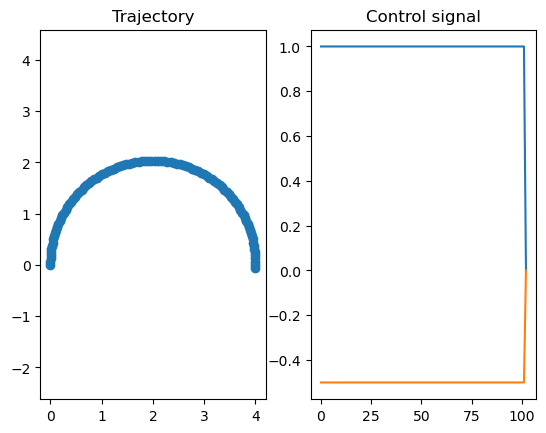

In [196]:
fig, axs = plt.subplots(1,2)
#Plotting the reference trajectory
axs[0].scatter(state_stack[:,0],state_stack[:,1])
axs[0].axis("equal")
axs[0].set_title("Trajectory")

#Plotting the control signal 
axs[1].plot(control_stack[:,0])
axs[1].set_title("Control signal")
axs[1].plot(control_stack[:,1], "tab:orange")

In [197]:
optimal_path = np.array([0,0,math.pi])

for ii in np.linspace(0,2*math.pi,102):
    optimal_path = np.vstack((optimal_path, [4/(2*math.pi)*ii, 0, math.pi/2]))

optimal_path.flatten().shape

(309,)

In [198]:
# define the objective function
# How many states are we really optimizing when we are using the 
# optimize function?
# Position and Control signal for sure!

def objective(x,y):
    #x: state vector
    #y: reference vector.
    #All objective functions in SciPy expect a numpy array
    #as their first argument which is to be optimized and must return
    #a float value.
    x = x.reshape(upstack.shape)
    x = x[:,[0,1,2]].flatten()
    #Other arguments can be provided.
    
    #Here is an implementation of the Quadratic Cost Function
    #J = ||S(t) - S_Ref(t)||^2
    return sum(abs(x - y)**2)

def consx(x):
    return [- x[i] + x[i-5] + dt*math.cos(x[i-3])*x[i-2] for i in range(5,len(x0)-5,5)]
def consy(x):
    return [- x[i+1] + x[i-4] + dt*math.sin(x[i-3])*x[i-2] for i in range(5,len(x0)-5,5)]
def const(x):
    return [- x[i+2] + x[i-3] + dt*x[i-1] for i in range(5,len(x0)-5,5)]

xnlc = NonlinearConstraint(consx,0,0)
ynlc = NonlinearConstraint(consy,0,0)
tnlc = NonlinearConstraint(const,0,0)

# eq_cons2 = [{'type':'eq', 
#         #Y
#         'fun': - x[i+1] + x[i-4] + dt*math.sin(x[i-3])*x[i-2]} for i in range(5,len(x0)-5,5)]
# eq_cons3 = [{'type':'eq', 
#         #Theta
#         'fun': - x[i+2] + x[i-3] + dt*x[i-1]} for i in range(5,len(x0)-5,5)]

In [ ]:
#Define y to be the reference path here. It is an additional argument
#to the optimize function
x0 = upstack.flatten()

res = minimize(objective, x0, args=(optimal_path.flatten()),method='trust-constr', constraints= [xnlc,ynlc,tnlc], options={'verbose':3})
sol = res.x.reshape(upstack.shape)

fig, axs = plt.subplots(1,2)
#Plotting the reference trajectory
axs[0].scatter(sol[:,0],sol[:,1])
axs[0].axis("equal")
axs[0].set_title("Trajectory")

#Plotting the control signal 
axs[1].plot(sol[:,3])
axs[1].set_title("Control signal")
axs[1].plot(sol[:,4], "tab:orange")

| niter |f evals|CG iter|  obj func   |tr radius |   opt    |  c viol  | penalty  |CG stop|
|-------|-------|-------|-------------|----------|----------|----------|----------|-------|
|   1   |  516  |   0   | +5.7471e+02 | 1.00e+00 | 6.41e+00 | 2.22e-16 | 1.00e+00 |   0   |
|   2   | 1032  |   1   | +5.3710e+02 | 7.00e+00 | 6.08e+00 | 2.99e-04 | 1.00e+00 |   2   |
|   3   | 1548  |   2   | +3.2387e+02 | 4.90e+01 | 3.77e+00 | 1.40e-02 | 1.00e+00 |   2   |
|   4   | 2064  |   5   | +1.6044e+02 | 7.31e+01 | 1.31e+00 | 2.75e-02 | 1.00e+00 |   4   |
|   5   | 2580  |  10   | +1.3965e+02 | 7.31e+01 | 1.07e+00 | 5.38e-03 | 1.00e+00 |   4   |
|   6   | 3096  |  15   | +1.3441e+02 | 7.31e+01 | 8.72e-01 | 7.26e-04 | 1.00e+00 |   4   |
|   7   | 3612  |  20   | +1.2985e+02 | 7.31e+01 | 7.50e-01 | 5.34e-04 | 1.00e+00 |   4   |
|   8   | 4128  |  25   | +1.2607e+02 | 7.31e+01 | 6.78e-01 | 3.81e-04 | 1.00e+00 |   4   |
|   9   | 4644  |  30   | +1.2280e+02 | 7.31e+01 | 6.83e-01 | 2.93e-04 | 1.00e+0

|  90   | 46440 |  298  | +5.4142e+01 | 7.31e+01 | 1.81e-01 | 6.17e-06 | 1.00e+00 |   4   |
|  91   | 46956 |  301  | +5.3955e+01 | 7.31e+01 | 1.81e-01 | 6.21e-06 | 1.00e+00 |   4   |
|  92   | 47472 |  304  | +5.3770e+01 | 7.31e+01 | 1.81e-01 | 6.24e-06 | 1.00e+00 |   4   |
|  93   | 47988 |  307  | +5.3587e+01 | 7.31e+01 | 1.81e-01 | 6.28e-06 | 1.00e+00 |   4   |
|  94   | 48504 |  310  | +5.3406e+01 | 7.31e+01 | 1.81e-01 | 6.32e-06 | 1.00e+00 |   4   |
|  95   | 49020 |  313  | +5.3227e+01 | 7.31e+01 | 1.81e-01 | 6.36e-06 | 1.00e+00 |   4   |
|  96   | 49536 |  316  | +5.3049e+01 | 7.31e+01 | 1.81e-01 | 6.40e-06 | 1.00e+00 |   4   |
|  97   | 50052 |  319  | +5.2873e+01 | 7.31e+01 | 1.80e-01 | 6.43e-06 | 1.00e+00 |   4   |
|  98   | 50568 |  322  | +5.2699e+01 | 7.31e+01 | 1.80e-01 | 6.45e-06 | 1.00e+00 |   4   |
|  99   | 51084 |  325  | +5.2527e+01 | 7.31e+01 | 1.80e-01 | 6.46e-06 | 1.00e+00 |   4   |
|  100  | 51600 |  328  | +5.2356e+01 | 7.31e+01 | 1.79e-01 | 6.47e-06 | 1.00e+0

|  180  | 92880 |  568  | +4.3377e+01 | 7.31e+01 | 1.29e-01 | 2.86e-06 | 1.00e+00 |   4   |
|  181  | 93396 |  571  | +4.3306e+01 | 7.31e+01 | 1.28e-01 | 2.82e-06 | 1.00e+00 |   4   |
|  182  | 93912 |  574  | +4.3236e+01 | 7.31e+01 | 1.28e-01 | 2.78e-06 | 1.00e+00 |   4   |
|  183  | 94428 |  577  | +4.3167e+01 | 7.31e+01 | 1.27e-01 | 2.74e-06 | 1.00e+00 |   4   |
|  184  | 94944 |  580  | +4.3098e+01 | 7.31e+01 | 1.27e-01 | 2.70e-06 | 1.00e+00 |   4   |
|  185  | 95460 |  583  | +4.3030e+01 | 7.31e+01 | 1.27e-01 | 2.68e-06 | 1.00e+00 |   4   |
|  186  | 95976 |  586  | +4.2962e+01 | 7.31e+01 | 1.26e-01 | 2.65e-06 | 1.00e+00 |   4   |
|  187  | 96492 |  589  | +4.2895e+01 | 7.31e+01 | 1.26e-01 | 2.62e-06 | 1.00e+00 |   4   |
|  188  | 97008 |  592  | +4.2829e+01 | 7.31e+01 | 1.25e-01 | 2.59e-06 | 1.00e+00 |   4   |
|  189  | 97524 |  595  | +4.2763e+01 | 7.31e+01 | 1.25e-01 | 2.57e-06 | 1.00e+00 |   4   |
|  190  | 98040 |  598  | +4.2697e+01 | 7.31e+01 | 1.25e-01 | 2.54e-06 | 1.00e+0

|  270  |139320 |  820  | +3.8530e+01 | 7.31e+01 | 9.88e-02 | 1.50e-06 | 1.00e+00 |   4   |
|  271  |139836 |  822  | +3.8485e+01 | 7.31e+01 | 9.86e-02 | 1.50e-06 | 1.00e+00 |   4   |
|  272  |140352 |  824  | +3.8440e+01 | 7.31e+01 | 9.83e-02 | 1.49e-06 | 1.00e+00 |   4   |
|  273  |140868 |  826  | +3.8395e+01 | 7.31e+01 | 9.81e-02 | 1.49e-06 | 1.00e+00 |   4   |
|  274  |141384 |  828  | +3.8350e+01 | 7.31e+01 | 9.79e-02 | 1.48e-06 | 1.00e+00 |   4   |
|  275  |141900 |  830  | +3.8305e+01 | 7.31e+01 | 9.76e-02 | 1.47e-06 | 1.00e+00 |   4   |
|  276  |142416 |  832  | +3.8260e+01 | 7.31e+01 | 9.74e-02 | 1.47e-06 | 1.00e+00 |   4   |
|  277  |142932 |  834  | +3.8216e+01 | 7.31e+01 | 9.72e-02 | 1.46e-06 | 1.00e+00 |   4   |
|  278  |143448 |  836  | +3.8171e+01 | 7.31e+01 | 9.69e-02 | 1.45e-06 | 1.00e+00 |   4   |
|  279  |143964 |  838  | +3.8126e+01 | 7.31e+01 | 9.67e-02 | 1.45e-06 | 1.00e+00 |   4   |
|  280  |144480 |  840  | +3.8081e+01 | 7.31e+01 | 9.65e-02 | 1.44e-06 | 1.00e+0

In [158]:
x0 = np.zeros(upstack.flatten().size)
sol[:,[0,1,2]].shape

(103, 3)

In [ ]:
z = [1,2,3,4,5,6,7,8,9,10] #arbitrary list elements that we need

def f(x0):
    #Counter variables. Start at the first state.
    i = 5
    
    for j in range(5,len(x0)+5,5):
        print(j)
        

    
    
z1 = np.asarray(z[5:]) 
z2 = np.asarray(z[:-5])

In [ ]:
f(x0)